# Ultility and Preparation

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [2]:
import sys
sys.path.append('..')

from src.dataset import SeaTurtleDataset

## A. Reduce Dataset size while implement models

In [3]:
INDIVIDUALS = 10
TRAIN_ENCOUNTERS = 2
TEST_ENCOUNTERS = 1

In [4]:
df = pd.read_csv('../data/metadata_splits.csv')
df.head()

,id,width,height,file_name,timestamp,identity,date,year,split_closed,split_closed_random,split_open,clarity
0,1,2000,1333,images/t001/CAluWEgwPX.JPG,2014-07-14 14:49:45,t001,2014-07-14,2014,test,test,train,3
1,2,2000,1333,images/t001/EKyrFKHQzh.JPG,2014-07-14 14:48:49,t001,2014-07-14,2014,test,train,train,2
2,3,2000,1333,images/t001/ELAvEqeXxT.JPG,2014-07-14 14:49:48,t001,2014-07-14,2014,test,train,train,2
3,4,2000,1124,images/t001/IxRLFwTGCv.JPG,2010-07-02 14:09:40,t001,2010-07-02,2010,train,test,train,3
4,5,2000,1333,images/t001/LKCJAhfLBJ.JPG,2014-07-14 14:48:28,t001,2014-07-14,2014,test,test,train,4


In [5]:
df_identity = df.groupby(['identity'])['date'].nunique().sort_values(ascending=False)

identity_ids = df_identity[df_identity > 3].head(INDIVIDUALS).index.tolist()

print(identity_ids)

['t217', 't243', 't048', 't323', 't063', 't110', 't033', 't236', 't221', 't398']


In [6]:
df = df[df['identity'].isin(identity_ids)]
print('Identity in the dataset:', df['identity'].unique())
print('Number of Identity:', df['identity'].nunique())
print('Number of images:', len(df))

Identity in the dataset: ['t033' 't048' 't063' 't110' 't217' 't221' 't236' 't243' 't323' 't398']
Number of Identity: 10
Number of images: 1113


In [7]:
# Alternative approach with more explicit date selection
def select_encounters_per_identity(group):
    result_frames = []
    
    # Get train encounters (max 2 dates)
    train_group = group[group['split_closed'] == 'train']
    if not train_group.empty:
        train_dates = train_group['date'].unique()[:TRAIN_ENCOUNTERS]
        train_images = train_group[train_group['date'].isin(train_dates)]
        result_frames.append(train_images)
    
    # Get test encounters (max 1 date)
    test_group = group[group['split_closed'] == 'test']
    if not test_group.empty:
        test_dates = test_group['date'].unique()[:TEST_ENCOUNTERS]
        test_images = test_group[test_group['date'].isin(test_dates)]
        result_frames.append(test_images)
    
    return pd.concat(result_frames, ignore_index=True) if result_frames else pd.DataFrame()

# Apply to each identity
df = df.groupby('identity')\
        .apply(select_encounters_per_identity)\
        .reset_index(drop=True)\
        .drop(columns=['split_closed_random', 'split_open', 'year'])

df.head()

/var/folders/yh/9qq7z2f14f14bdj_1k2673700000gn/T/ipykernel_58156/3537147572.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('identity')\


,id,width,height,file_name,timestamp,identity,date,split_closed,clarity
0,658,2000,1333,images/t033/ASlqqAwMwC.jpg,2019-06-11 17:37:43,t033,2019-06-11,train,4
1,663,2000,1500,images/t033/EPdYwOtObe.JPG,2012-07-11 17:19:42,t033,2012-07-11,train,1
2,670,2000,1500,images/t033/MjYzXFYVGd.JPG,2012-07-11 17:20:23,t033,2012-07-11,train,2
3,673,2000,1333,images/t033/OVRRkbHfNd.jpg,2019-06-11 18:10:18,t033,2019-06-11,train,2
4,689,2000,1333,images/t033/aCthhRWYxG.jpg,2019-06-11 17:35:52,t033,2019-06-11,train,2


In [8]:
# Verify the filtering worked correctly
print("Dates per identity and split after filtering:")
dates_per_identity = df.groupby(['identity', 'split_closed'])['date'].nunique()
print(dates_per_identity)

print(f"\nTotal images after filtering: {len(df)}")
print(f"Images per identity and date:")
print(df.groupby(['identity', 'split_closed', 'date']).size())

df.head()

Dates per identity and split after filtering:
identity  split_closed
t033      test            1
          train           2
t048      test            1
          train           2
t063      test            1
          train           2
t110      test            1
          train           2
t217      test            1
          train           2
t221      test            1
          train           2
t236      test            1
          train           2
t243      test            1
          train           2
t323      test            1
          train           2
t398      test            1
          train           2
Name: date, dtype: int64

Total images after filtering: 249
Images per identity and date:
identity  split_closed  date      
t033      test          2020-06-21    13
          train         2012-07-11     4
                        2019-06-11     5
t048      test          2016-10-02     5
          train         2015-07-26    14
                        2016-06-26     6


,id,width,height,file_name,timestamp,identity,date,split_closed,clarity
0,658,2000,1333,images/t033/ASlqqAwMwC.jpg,2019-06-11 17:37:43,t033,2019-06-11,train,4
1,663,2000,1500,images/t033/EPdYwOtObe.JPG,2012-07-11 17:19:42,t033,2012-07-11,train,1
2,670,2000,1500,images/t033/MjYzXFYVGd.JPG,2012-07-11 17:20:23,t033,2012-07-11,train,2
3,673,2000,1333,images/t033/OVRRkbHfNd.jpg,2019-06-11 18:10:18,t033,2019-06-11,train,2
4,689,2000,1333,images/t033/aCthhRWYxG.jpg,2019-06-11 17:35:52,t033,2019-06-11,train,2


In [9]:
df.to_csv('../data/metadata_splits_filtered.csv', index=False)
df[df['split_closed'] == 'train'].to_csv('../data/metadata_splits_filtered_closed_train.csv', index=False)
df[df['split_closed'] == 'test'].to_csv('../data/metadata_splits_filtered_closed_test.csv', index=False)

## B. Visualizing the Dataset

In [10]:
dataset_dir='../data'

train_csv_path = os.path.join(dataset_dir, "metadata_splits_filtered_closed_train.csv")
test_csv_path = os.path.join(dataset_dir, "metadata_splits_filtered_closed_test.csv")

train_dataset = SeaTurtleDataset(annotations_file=train_csv_path, img_dir=dataset_dir)
test_dataset = SeaTurtleDataset(annotations_file=test_csv_path, img_dir=dataset_dir)

In [11]:
train_dataset.img_labels.head()

,id,width,height,file_name,timestamp,identity,date,split_closed,clarity
0,658,2000,1333,images/t033/ASlqqAwMwC.jpg,2019-06-11 17:37:43,t033,2019-06-11,train,4
1,663,2000,1500,images/t033/EPdYwOtObe.JPG,2012-07-11 17:19:42,t033,2012-07-11,train,1
2,670,2000,1500,images/t033/MjYzXFYVGd.JPG,2012-07-11 17:20:23,t033,2012-07-11,train,2
3,673,2000,1333,images/t033/OVRRkbHfNd.jpg,2019-06-11 18:10:18,t033,2019-06-11,train,2
4,689,2000,1333,images/t033/aCthhRWYxG.jpg,2019-06-11 17:35:52,t033,2019-06-11,train,2


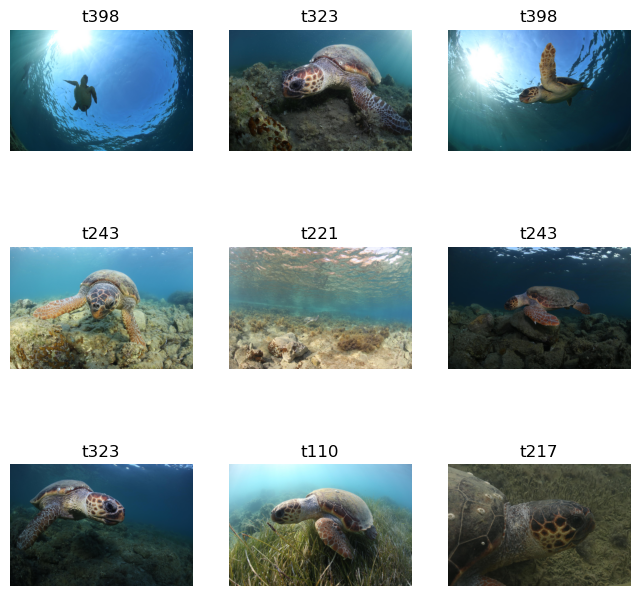

In [12]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()